# Loading in the Data

In [37]:
import os
import sqlite3

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import pandas as pd
import pycountry
import seaborn as sns

QUERY_ALL = """
SELECT 
    Users.user_id AS user_id, 
    Users.creation_time AS user_creation_time, 
    Tweets.creation_time AS tweet_creation_time,
    Tweets.tweet_id,
    Tweets.full_text,
    Tweets.lang,
    Tweets.country_code,
    Tweets.sentiment_score
FROM Users
INNER JOIN Tweets ON Users.user_id = Tweets.user_id;
"""

QUERY_CONVERSATIONS = """
SELECT * FROM Conversations;
"""

DTYPES = {
"user_id": "object",
"tweet_id": "object",
"full_text": "object",
"lang": "category",
"country_code": "category",
"sentiment_score": "float32",
}

COMPANY_NAME_TO_ID = {
    "Klm": "56377143",
    "Air France": "106062176",
    "British Airways": "18332190",
    "American Air": "22536055",
    "Lufthansa": "124476322",
    "Air Berlin": "26223583",
    "Air Berlin assist": "2182373406",
    "easyJet": "38676903",
    "Ryanair": "1542862735",
    "Singapore Airlines": "253340062",
    "Qantas": "218730857",
    "Etihad Airways": "45621423",
    "Virgin Atlantic": "20626359",
}
COMPANY_ID_LIST = list(COMPANY_NAME_TO_ID.values())
COMPANY_NAME_LIST = list(COMPANY_NAME_TO_ID.keys())
COMPANY_ID_TO_NAME = {v: k for k, v in COMPANY_NAME_TO_ID.items()}

def get_full_language_name(language_code: str,
                           default: str="Undefined Language") -> str:
    """
    Convert a two-letter language code (ISO 639-1) to its full language name.
    
    Parameters:
    language_code (str): The two-letter ISO 639-1 language code.
    
    Returns:
    str: The full name of the language or a message indicating the code was not found.
    """
    if language_code=="Other languages":
        return language_code
    language = pycountry.languages.get(alpha_2=language_code, default=default)
    if language != default:
        language = language.name
    return language


def get_country_name(country_code: str, default: str="Unknown Country") -> str:
    """
    Convert a two-letter country code (ISO 3166-1 alpha-2|) to its full country name.
    
    Parameters:
    country_code (str): The two-letter ISO 3166-1 alpha-2 country code.
    
    Returns:
    str: The full name of the country or a message indicating the code was not found.
    """
    country = pycountry.countries.get(alpha_2=country_code, default=default)
    if country != default:
        country = country.name
    return country

def get_tweets_with_users(query: str, path: str) -> pd.DataFrame:
    with sqlite3.connect(path) as connection:
        return pd.read_sql_query(query, connection,
                                 dtype=DTYPES,
                                 parse_dates=["tweet_creation_time", "user_creation_time"],
                                 index_col='tweet_id')


def get_conversations(query: str, path: str) -> pd.DataFrame:
    with sqlite3.connect(path) as connection:
        return pd.read_sql_query(query, connection,
                                 dtype={"conversation_id": "object", "tweet_order": "int16", "tweet_id": "object"},
                                 index_col=["conversation_id", "tweet_order"])

def get_categories(query, path):
    with sqlite3.connect(path) as connection:
        return pd.read_sql_query(query, connection)


path =  os.path.join(
    os.path.dirname(   
        os.path.dirname(
            os.getcwd()
        )),
    "data_processed", "local_backup.db")
df_tweets_and_users = get_tweets_with_users(QUERY_ALL, path)
df_conversations = get_conversations(QUERY_CONVERSATIONS, path)

df_all = df_conversations.merge(df_tweets_and_users, left_on='tweet_id', right_index=True, how='left')
df_all

df_reset = df_all.reset_index()
df_reset['airline'] = df_reset['user_id'].map(COMPANY_ID_TO_NAME)

df_categories = get_categories("SELECT * from ConversationsCategory WHERE category IS NOT 'No Category'", path)

df_merged = pd.merge(df_reset, df_categories, on='conversation_id')
df_merged.set_index('conversation_id', inplace=True)

# DF MERGED IS THE FINAL DATAFRAME!!! IT COMBINES DF_CATEGORIES AND DF_RESET!

# INTERNAL ANALYSIS

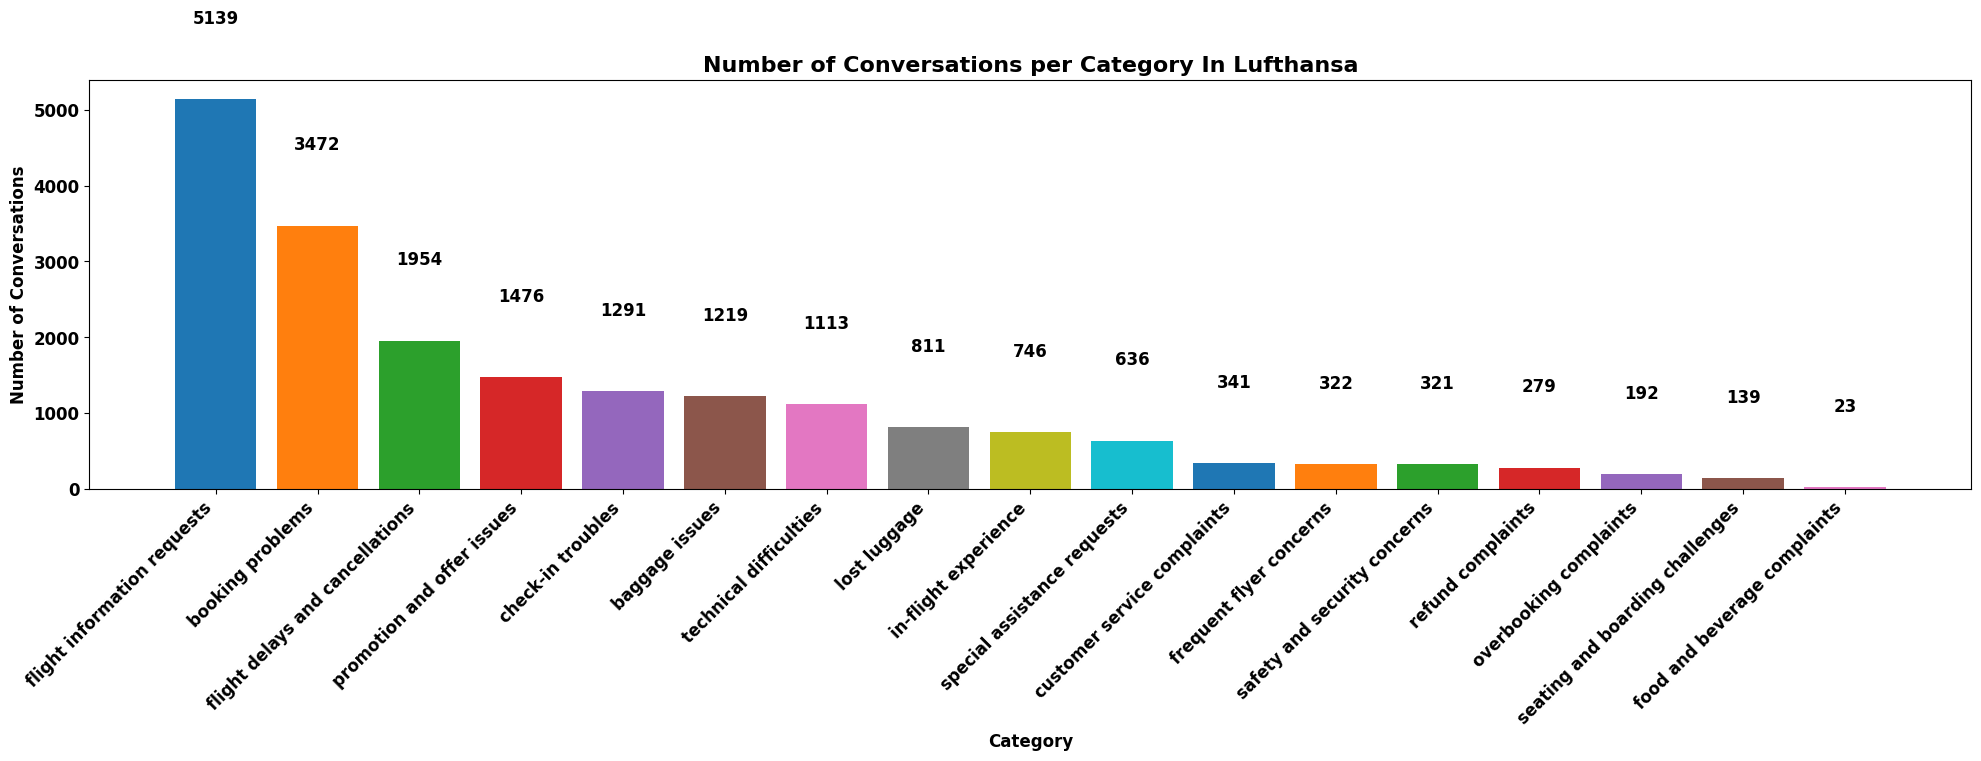

In [28]:
# Calculate the category counts
category_counts = df_merged[df_merged['airline']=='Lufthansa']['category'].value_counts()

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(20, 8))
bars = plt.bar(category_counts.index, category_counts.values, color=colors[:len(category_counts)])

plt.xlabel('Category', fontsize=12, fontweight='bold')
plt.ylabel('Number of Conversations', fontsize=12, fontweight='bold')
plt.title('Number of Conversations per Category In Lufthansa', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold', ha='right')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1000, int(yval), ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels


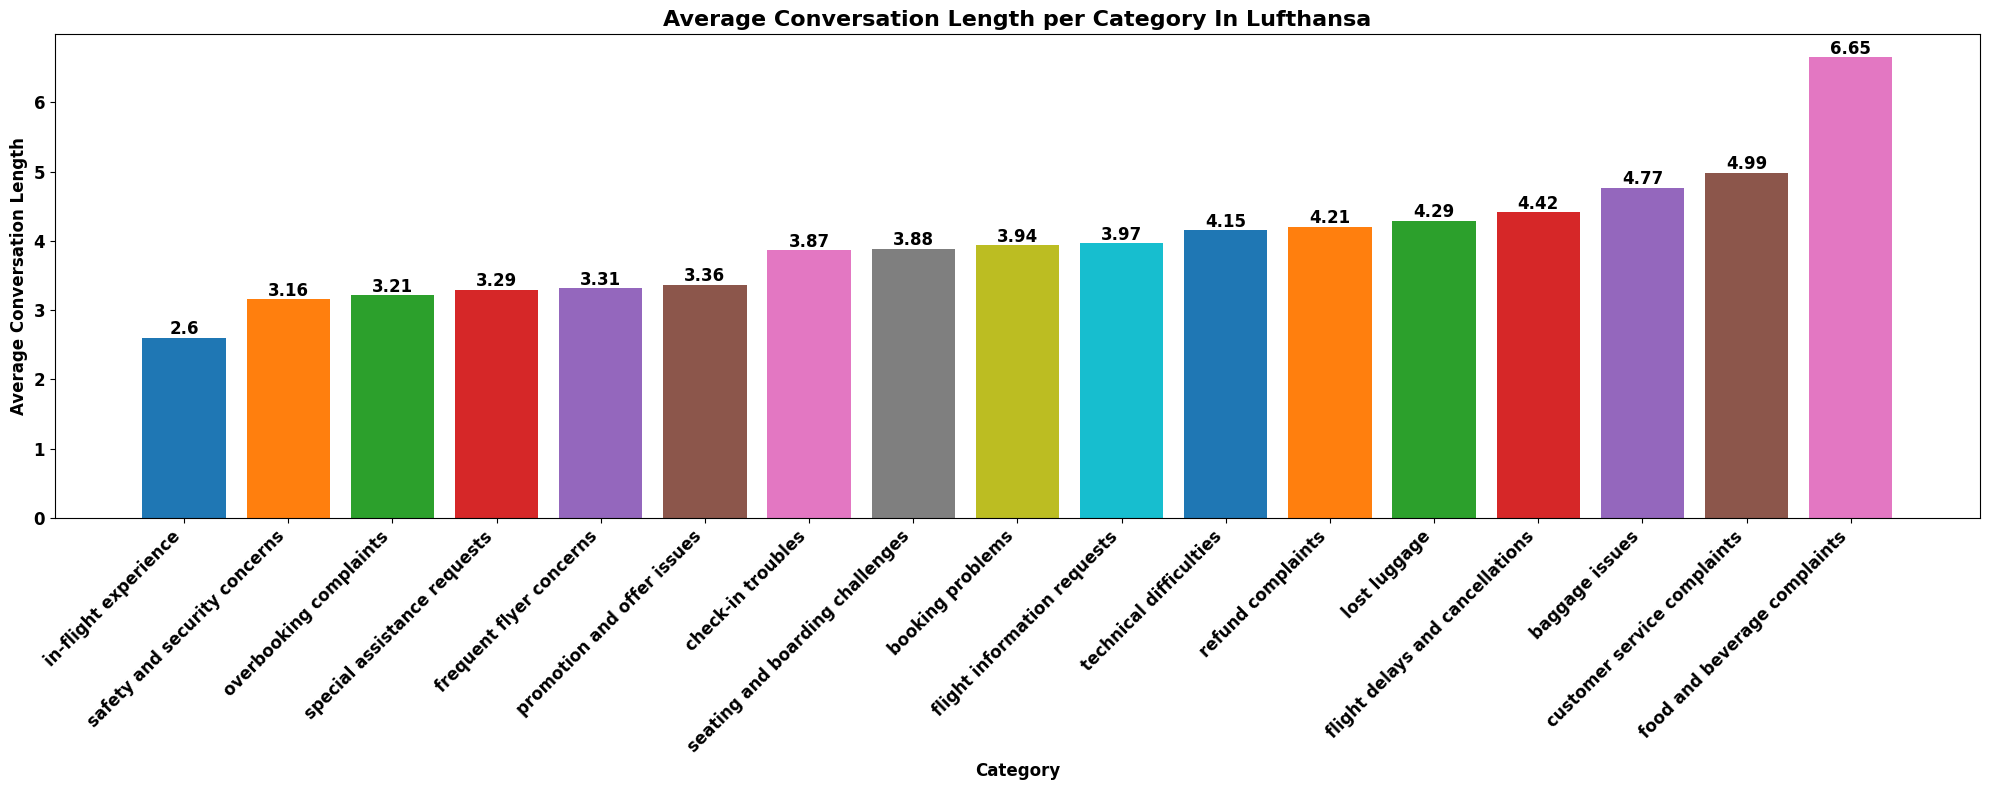

In [55]:
conversation_lengths = df_reset['conversation_id'].value_counts()

# Merge the conversation lengths with df_categories to get the category information
together = pd.merge(conversation_lengths, df_merged, on='conversation_id')

together = together[together['airline'] == "Lufthansa"]

# Compute the average conversation length per category
avg_conversation_length_per_category = together.groupby('category')['count'].mean().sort_values()


# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(20, 8))
bars = plt.bar(avg_conversation_length_per_category.index, avg_conversation_length_per_category.values, color=colors[:len(avg_conversation_length_per_category)])

plt.xlabel('Category', fontsize=12, fontweight='bold')
plt.ylabel('Average Conversation Length', fontsize=12, fontweight='bold')
plt.title('Average Conversation Length per Category In Lufthansa', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold', ha='right')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, round(yval, 2), ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels



In [66]:
 # Do a plot for response time
# Do a plot for languages

# EXTERNAL ANALYSIS